# Standford 120 Dogs Dataset - Transfer Learning with ResNet50 Project

## 0. Empty Disk space

In [1]:
import torch

# Clear cache from GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# If using Apple Silicon (MPS)
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

## 1. Import Key Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder 
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

## 2. Create the Device Agonistic Code

In [3]:
import torch

# ----------------------------- Smart DEVICE -----------------------------
DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cpu")
)

In [4]:
import torch

# Clear cache from GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# If using Apple Silicon (MPS)
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

In [5]:
# Device-agnostic setup (MPS, CUDA, CPU)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: mps


## 3. Ensure Reproducibility of Results

In [6]:
import os
import random
import numpy as np
import torch

# -------------------- Reproducibility (non-intrusive) --------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Optional but recommended for complete determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 4. Data Loading and Preprocessing

In [8]:
from torchvision import datasets
from torch.utils.data import random_split
from torchvision import transforms

# ----------------------------- Paths and Constants -----------------------------
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_WORKERS = 0 
VAL_SPLIT = 0.2
NUM_EPOCHS = 25

train_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    transforms.Resize(256),
    transforms.CenterCrop(224),  # final input stays 224x224 for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------------- Dataset Loading -----------------------------
base_dir = "./data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Load dataset for splitting
full_train_dataset = datasets.ImageFolder(train_dir)
class_names = [name.split('-')[-1] for name in full_train_dataset.classes] # Extract class names
num_classes = len(class_names)

# Split into train/validation sets
train_size = int((1 - VAL_SPLIT) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Train dataset transforms
train_dataset.transform = train_transforms

# Apply validation transforms separately (avoid data leakage)
val_dataset.dataset.transform = val_test_transforms

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# ----------------------------- DataLoaders -----------------------------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [9]:
# Batch counts
len(train_loader), len(val_loader), len(test_loader)

(300, 75, 269)

In [10]:
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}, Label shape: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224]), Label shape: torch.Size([32])


## 5. Image Visualization

### 5.1 Static Visualized Images

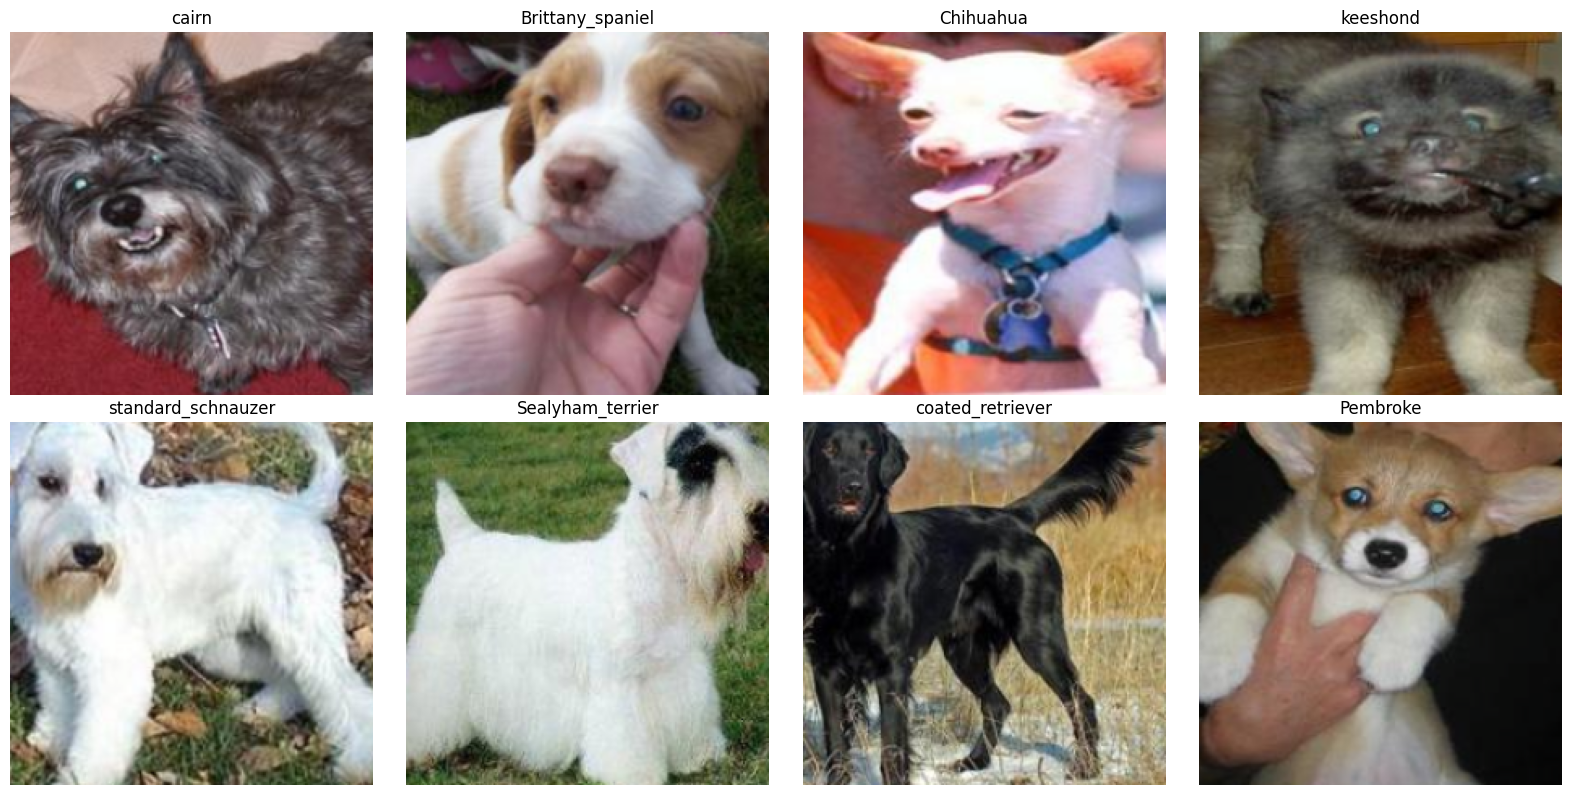

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for i in range(8):
    img_tensor, label = train_dataset[i]  # Already a tensor with transforms

    # De-normalize and convert to image for display
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

### Untransformed Images

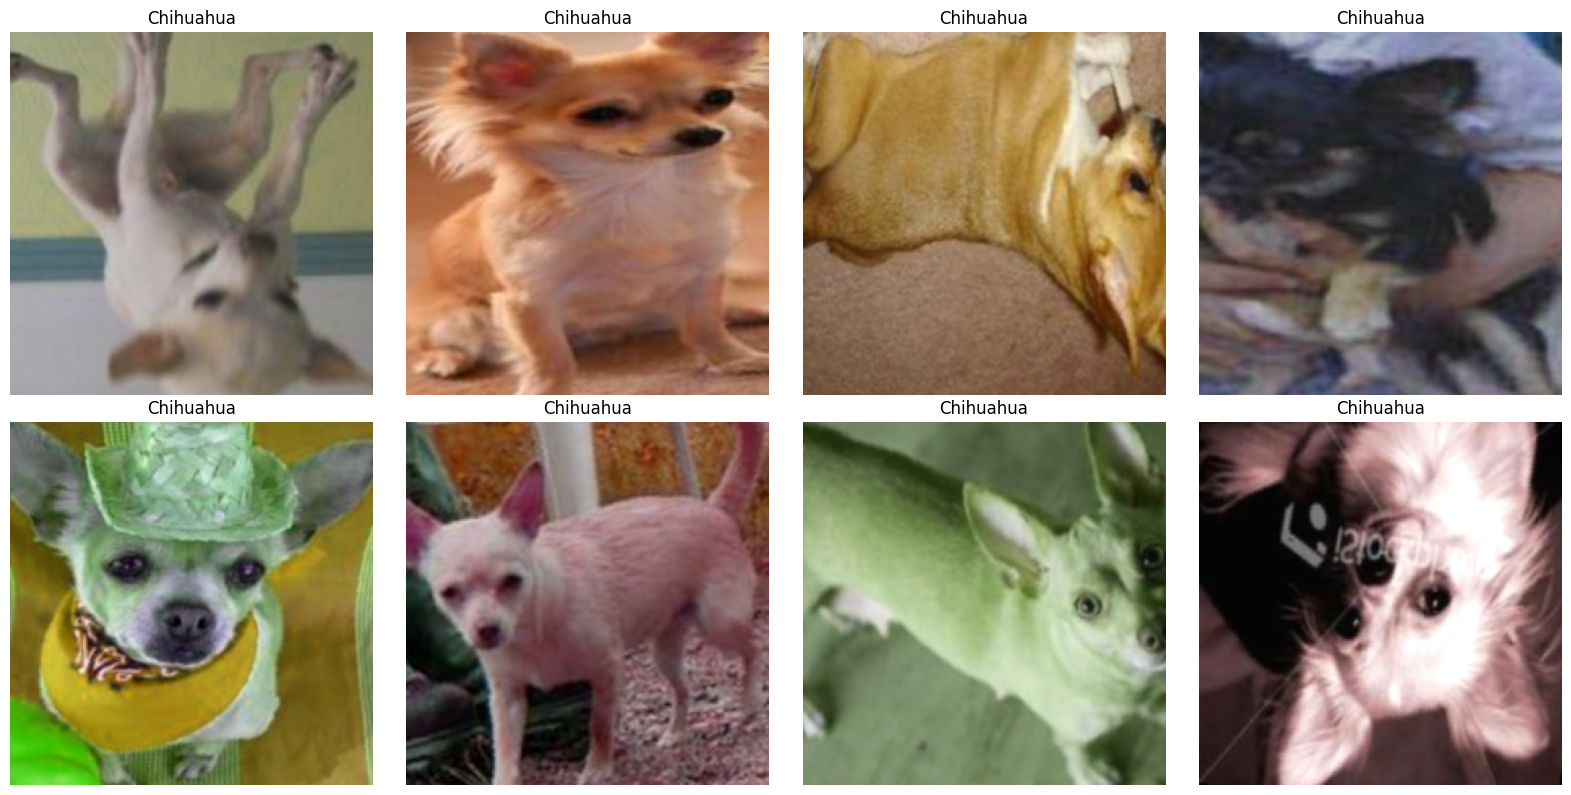

In [12]:
from torchvision import datasets

# Reload raw dataset without transforms
raw_train_dataset = datasets.ImageFolder(train_dir)  # no transform

plt.figure(figsize=(16, 8))

for i in range(8):
    pil_img, label = raw_train_dataset[i]
    img_tensor = train_transforms(pil_img)  # Now safe to apply

    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

### 5.2 Randomly Visualized Images

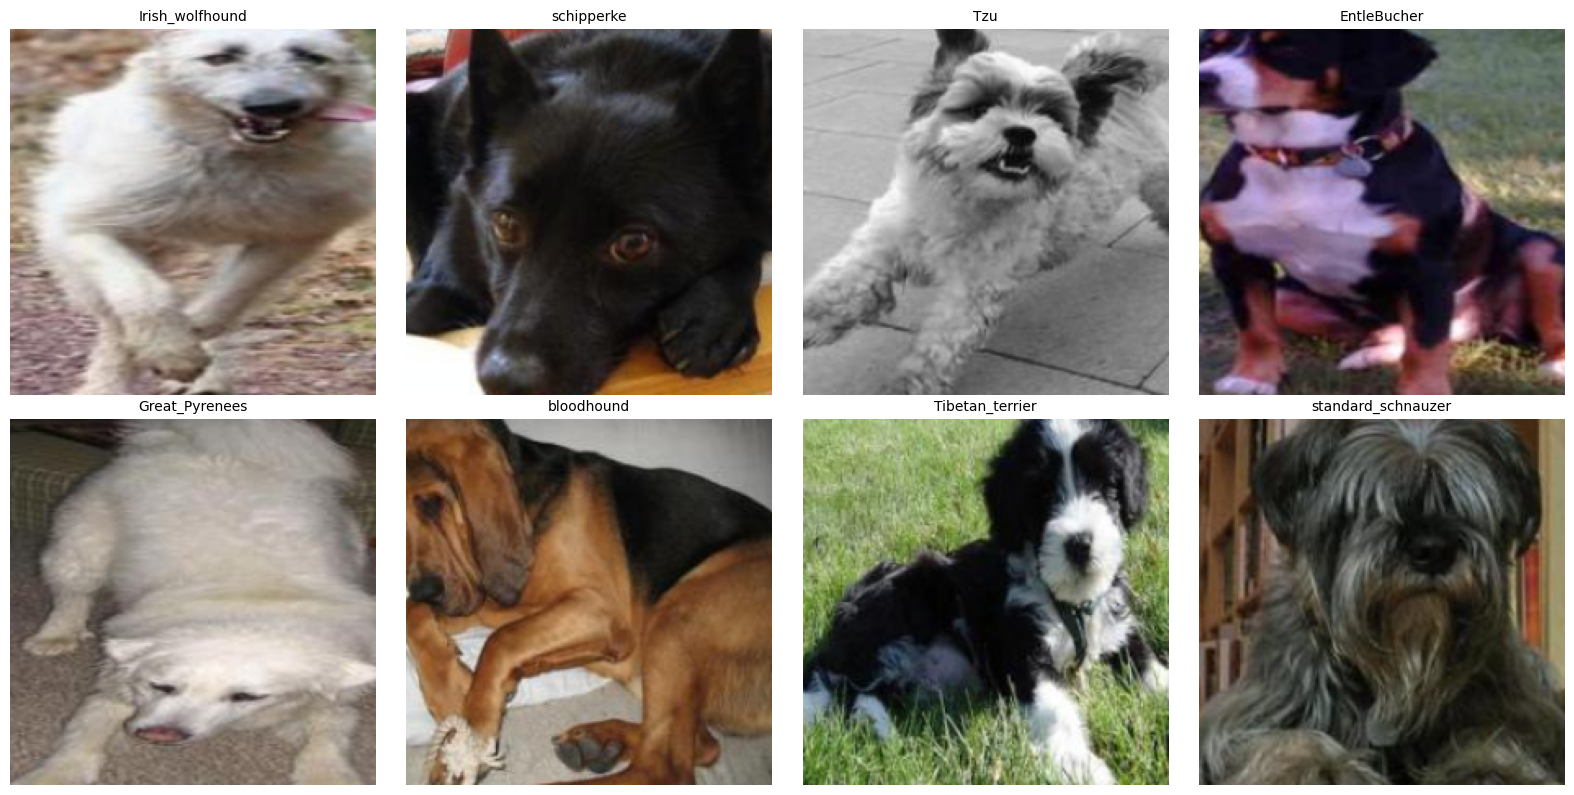

In [13]:
# Plot 8 images safely from train_dataset
plt.figure(figsize=(16, 8))
for i in range(8):
    img_tensor, label = val_dataset[i]  # Single (img, label)
    
    # De-normalize
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)

    label_text = class_names[label].split("-")[-1]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label_text, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 5.3 Randomly Visualized Images from Test set

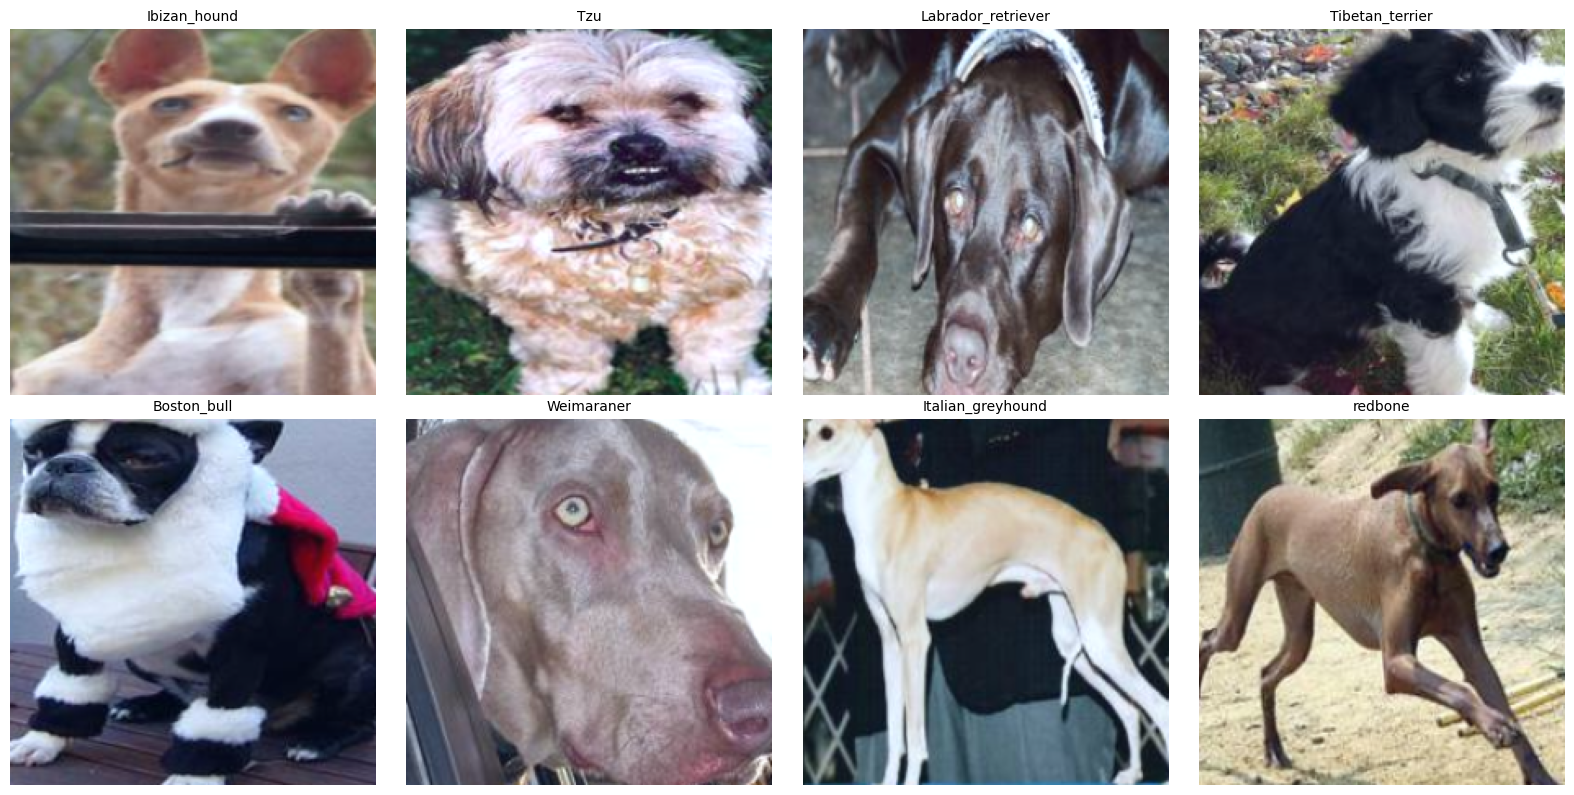

In [14]:
import random

# Randomly sample 8 indices from the training dataset
random_indices = random.sample(range(len(test_dataset)), 8)

# Plot randomly selected images
plt.figure(figsize=(16, 8))
for i, idx in enumerate(random_indices):
    image_tensor, label_idx = test_dataset[idx]
    image = image_tensor.permute(1, 2, 0).numpy()
    image = (image * 0.229 + 0.485).clip(0, 1)  # Unnormalize
    
    label_text = class_names[label_idx].split('-')[-1]
    
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(label_text, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
class_names[:15]

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'tan_coonhound']

## 6. Model Configuration

### 6.1 Modify the Pre-trained ResNet50 Model for Transfer Learning

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -------------------- Model Setup -------------------- #
def setup_resnet50_for_transfer_learning(num_classes: int):
    model = models.resnet50(pretrained=True)
    
    # Freeze all parameters in the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final fully connected layer (classifier)
    # The 'fc' layer in ResNet50 is the final classification layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

In [ ]:
# import torch.nn as nn
# from torchvision import models

# # -------------------- Improved ResNet50 Transfer Learning -------------------- #
# def setup_resnet50_for_transfer_learning(num_classes: int):
#     model = models.resnet50(pretrained=True)

#     # Freeze convolutional backbone
#     for param in model.parameters():
#         param.requires_grad = False

#     # Number of features from the original fully connected layer
#     num_ftrs = model.fc.in_features

#     # Modify the FC layer with a deeper classifier head
#     model.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 512),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(512),
#         nn.Dropout(0.5),           # helps reduce overfitting

#         nn.Linear(512, 256),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(256),
#         nn.Dropout(0.3),

#         nn.Linear(256, num_classes)
#     )

#     return model

<!-- nn.Dropout(0.5) How about a dropout  -->

### 6.2 Create the Train and Evaluation Loops

In [36]:
import copy
import torch

def train_resnet_model(model, 
                       train_loader,
                       test_loader,
                       criterion, 
                       optimizer, 
                       scheduler, 
                       num_epochs, 
                       device,
                       save_path="resnet50_best.pth",  # NOT a folder!
                       save_best_by="loss"):  # or 'accuracy'

    model.to(device)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = float("inf") if save_best_by == "loss" else 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print(f"\n🌀 Epoch {epoch+1}/{num_epochs}")

        # -------- Training -------- #
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / total
        train_accuracy = 100 * correct / total
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_accuracy)

        # -------- Evaluation -------- #
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]", leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = test_loss / total
        test_accuracy = 100 * correct / total
        history["test_loss"].append(avg_test_loss)
        history["test_acc"].append(test_accuracy)

        # Step scheduler
        scheduler.step(avg_test_loss)

        # Logging
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Test  Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

        # Track best model (but do NOT save yet)
        if save_best_by == "loss" and avg_test_loss < best_metric:
            best_metric = avg_test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        elif save_best_by == "accuracy" and test_accuracy > best_metric:
            best_metric = test_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

    # Final model saving
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    print(f"\nFinal best model saved from Epoch\
           {best_epoch} with best {save_best_by}: {best_metric:.4f}")
    
    # Final model saving
    model.load_state_dict(best_model_wts)
    model.cpu()  # workaround for MPS/macos saving bug

    # Optional cleanup of previous file
    if os.path.exists(save_path):
        os.remove(save_path)

    torch.save(model.state_dict(), save_path)
    print(f"\nFinal best model saved from Epoch {best_epoch} with best {save_best_by}: {best_metric:.4f}")

    model.to(DEVICE)  # return to training device if needed


    return model, history

### 6.3 Plot the Model Training Process Curves

In [37]:
# -------------------- Plot Curves -------------------- #
def plot_training_curves(history: dict):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Train Accuracy')
    plt.plot(epochs, history['test_acc'], 'ro-', label='Test Accuracy')
    plt.title('ResNet: Training vs Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    plt.plot(epochs, history['test_loss'], 'ro-', label='Test Loss')
    plt.title('ResNet: Training vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

### 6.4 Train the Model

In [38]:
# -------------------- Example Usage -------------------- #
NUM_EPOCHS = 30
model_ft = setup_resnet50_for_transfer_learning(len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.00025, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=3)
                                            
# Train and evaluate the model                                               
model_ft, history = train_resnet_model(
    model_ft, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer_ft, 
    scheduler, 
    num_epochs=NUM_EPOCHS, 
    save_path = "resnet50_best.pth",
    save_best_by="loss",
    device=DEVICE
)

/Users/emmanueldanielchonza/Documents/Deep Learning/Practical-Deep-Learning/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/emmanueldanielchonza/Documents/Deep Learning/Practical-Deep-Learning/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🌀 Epoch 1/30


Epoch 1 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 4.5922, Accuracy: 8.71%
Test  Loss: 4.2848, Accuracy: 28.32%

🌀 Epoch 2/30


Epoch 2 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 4.1018, Accuracy: 35.70%
Test  Loss: 3.7970, Accuracy: 52.77%

🌀 Epoch 3/30


Epoch 3 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 3.6659, Accuracy: 52.73%
Test  Loss: 3.3479, Accuracy: 63.97%

🌀 Epoch 4/30


Epoch 4 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 3.2735, Accuracy: 62.95%
Test  Loss: 2.9744, Accuracy: 67.47%

🌀 Epoch 5/30


Epoch 5 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 2.9376, Accuracy: 66.73%
Test  Loss: 2.6538, Accuracy: 70.42%

🌀 Epoch 6/30


Epoch 6 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 2.6479, Accuracy: 69.92%
Test  Loss: 2.4250, Accuracy: 72.46%

🌀 Epoch 7/30


Epoch 7 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 2.4004, Accuracy: 72.67%
Test  Loss: 2.1641, Accuracy: 73.86%

🌀 Epoch 8/30


Epoch 8 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 2.1952, Accuracy: 73.80%
Test  Loss: 1.9766, Accuracy: 74.97%

🌀 Epoch 9/30


Epoch 9 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 2.0222, Accuracy: 75.02%
Test  Loss: 1.8152, Accuracy: 76.03%

🌀 Epoch 10/30


Epoch 10 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.8818, Accuracy: 75.83%
Test  Loss: 1.6978, Accuracy: 76.59%

🌀 Epoch 11/30


Epoch 11 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.7561, Accuracy: 76.68%
Test  Loss: 1.5799, Accuracy: 77.05%

🌀 Epoch 12/30


Epoch 12 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.6497, Accuracy: 77.34%
Test  Loss: 1.5004, Accuracy: 77.55%

🌀 Epoch 13/30


Epoch 13 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.5660, Accuracy: 77.81%
Test  Loss: 1.4295, Accuracy: 77.41%

🌀 Epoch 14/30


Epoch 14 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.4860, Accuracy: 78.18%
Test  Loss: 1.3503, Accuracy: 78.41%

🌀 Epoch 15/30


Epoch 15 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.4192, Accuracy: 78.66%
Test  Loss: 1.2800, Accuracy: 78.73%

🌀 Epoch 16/30


Epoch 16 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.3646, Accuracy: 78.90%
Test  Loss: 1.2591, Accuracy: 78.46%

🌀 Epoch 17/30


Epoch 17 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.3058, Accuracy: 79.82%
Test  Loss: 1.2051, Accuracy: 79.06%

🌀 Epoch 18/30


Epoch 18 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.2634, Accuracy: 79.77%
Test  Loss: 1.1686, Accuracy: 79.07%

🌀 Epoch 19/30


Epoch 19 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.2253, Accuracy: 79.65%
Test  Loss: 1.1396, Accuracy: 79.13%

🌀 Epoch 20/30


Epoch 20 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.1885, Accuracy: 79.88%
Test  Loss: 1.1043, Accuracy: 79.72%

🌀 Epoch 21/30


Epoch 21 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 21 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.1555, Accuracy: 80.45%
Test  Loss: 1.0652, Accuracy: 80.15%

🌀 Epoch 22/30


Epoch 22 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 22 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.1204, Accuracy: 80.86%
Test  Loss: 1.0560, Accuracy: 79.49%

🌀 Epoch 23/30


Epoch 23 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 23 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.0982, Accuracy: 80.74%
Test  Loss: 1.0204, Accuracy: 79.99%

🌀 Epoch 24/30


Epoch 24 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 24 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.0708, Accuracy: 80.76%
Test  Loss: 1.0121, Accuracy: 79.79%

🌀 Epoch 25/30


Epoch 25 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 25 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.0469, Accuracy: 80.88%
Test  Loss: 1.0012, Accuracy: 79.83%

🌀 Epoch 26/30


Epoch 26 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 26 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 1.0263, Accuracy: 81.59%
Test  Loss: 0.9697, Accuracy: 79.86%

🌀 Epoch 27/30


Epoch 27 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 27 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 0.9988, Accuracy: 81.83%
Test  Loss: 0.9649, Accuracy: 80.02%

🌀 Epoch 28/30


Epoch 28 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 28 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 0.9842, Accuracy: 81.50%
Test  Loss: 0.9689, Accuracy: 79.65%

🌀 Epoch 29/30


Epoch 29 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 29 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 0.9647, Accuracy: 82.15%
Test  Loss: 0.9337, Accuracy: 80.51%

🌀 Epoch 30/30


Epoch 30 [Train]:   0%|          | 0/300 [00:01<?, ?it/s]

Epoch 30 [Test]:   0%|          | 0/269 [00:01<?, ?it/s]

Train Loss: 0.9534, Accuracy: 82.10%
Test  Loss: 0.9385, Accuracy: 79.71%

Final best model saved from Epoch           29 with best loss: 0.9337

Final best model saved from Epoch 29 with best loss: 0.9337


### 6.5 Visualize the Training Curve Trends

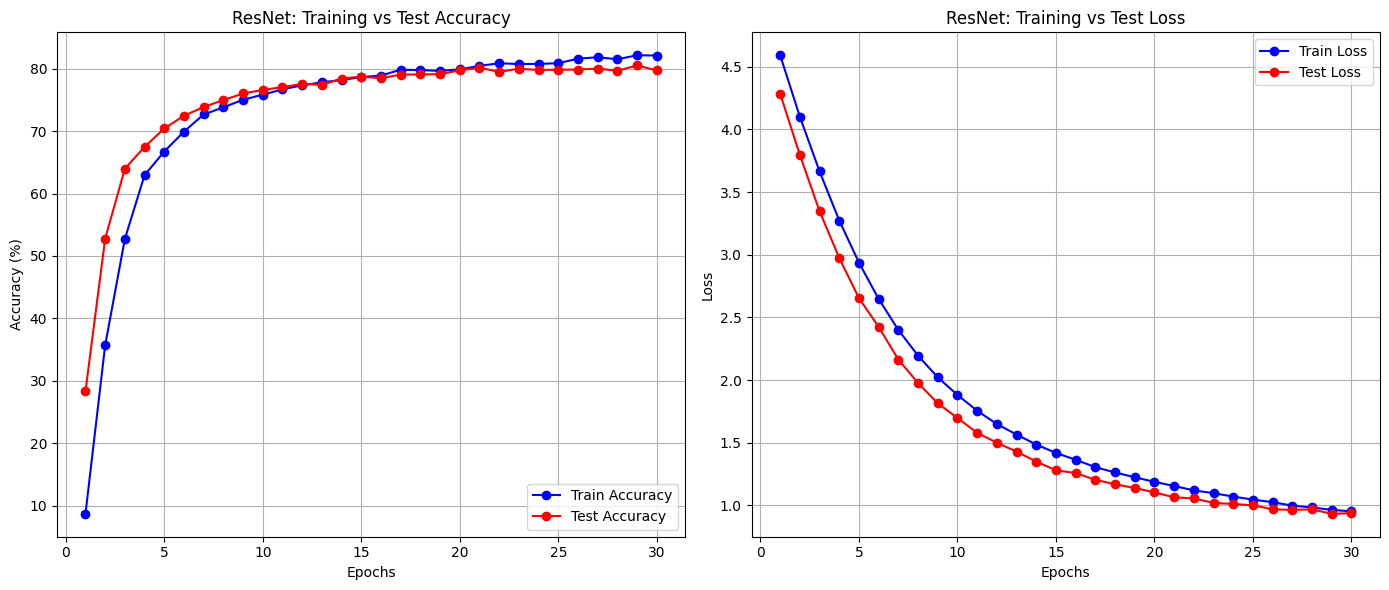

In [41]:
# Plot the training curves
plot_training_curves(history)

## 7. Inference Process

### 7.1 Save the Trained Model

In [ ]:
# # Save model
# MODEL_PATH = "resnet50_dog_classifier_ver1.pth"
# torch.save(model_ft.state_dict(), MODEL_PATH)

### 7.2 Load the model for inference or further training

In [42]:
def load_model(model_path, num_classes, device):
    model = models.resnet50(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load the model
model = load_model("resnet50_best.pth", 
                   num_classes=len(class_names), 
                   device=DEVICE)

### 7.3 Inference Pipeline for Custom Images Predictions

In [43]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


# 1. Define Your Class Names (120 classes)
base_dir = "./data"
train_dir = os.path.join(base_dir, "train")
train_dataset = datasets.ImageFolder(train_dir)
class_names = [name.split('-')[-1].lower() for name in train_dataset.classes]
num_classes = len(class_names)

# 3. Custom Inference Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")) + 
                                  glob(os.path.join(image_dir, "*.jpeg")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Set DEVICE
DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# 4. Load the Model
model = setup_resnet50_for_transfer_learning(num_classes=num_classes)
model.load_state_dict(torch.load("resnet50_best.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Define Transforms and Load Test Dataset
inference_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create inference dataset and loader
inference_dir = "custom_images/images"
custom_dataset = CustomImageDataset(inference_dir, transform=inference_transforms)
inference_loader = DataLoader(custom_dataset, batch_size=1, shuffle=False)

def predict_custom_images(model, dataloader, class_names, device=DEVICE, max_images=16):
    model.eval()
    shown = 0
    plt.figure(figsize=(20, 10))

    for images, image_paths in dataloader:
        if shown >= max_images:
            break

        images = images.to(device)

        with torch.no_grad():
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

        pred_label = class_names[preds.item()]
        confidence = conf.item() * 100

        # 🎨 Color code based on confidence threshold (green if ≥ 50%)
        title_color = "green" if confidence >= 4 else "red"

        # Unnormalize for display
        unnorm_img = images[0].cpu().permute(1, 2, 0).numpy()
        unnorm_img = unnorm_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        unnorm_img = unnorm_img.clip(0, 1)

        # Plot
        plt.subplot(2, 8, shown + 1)
        plt.imshow(unnorm_img)
        plt.axis("off")
        title = f"Pred: {pred_label}\nConf: {confidence:.2f}%"
        plt.title(title, color=title_color, fontsize=12)
        shown += 1

    plt.tight_layout()
    plt.show()

### 7.4 Display Prediction: Colored Predicted labels and Confidence

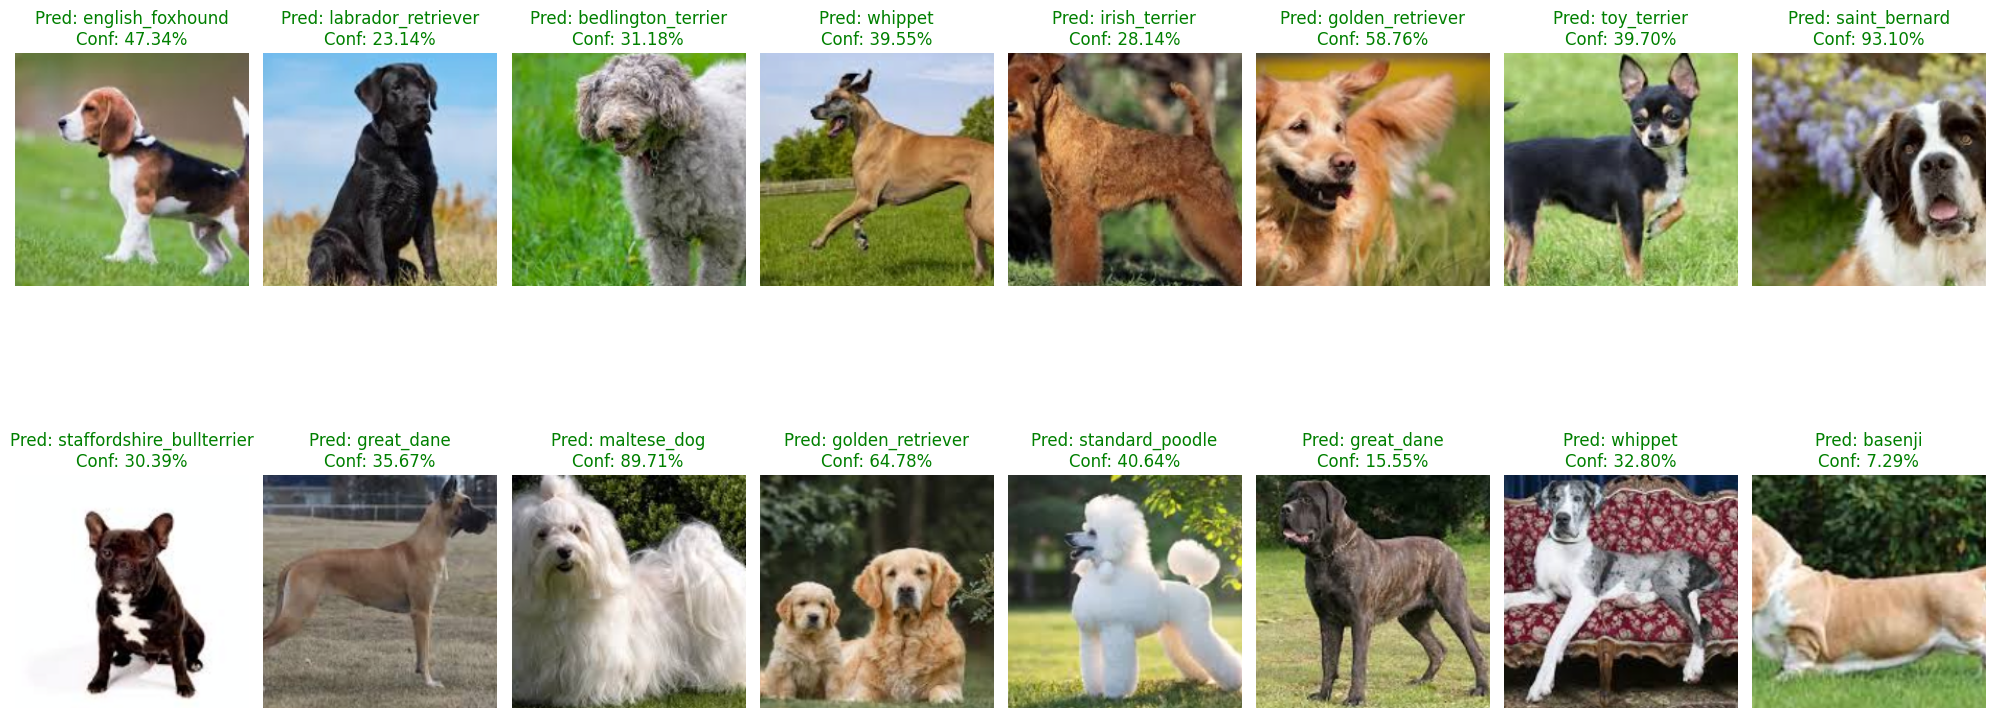

In [44]:
# Run the visualization
predict_custom_images(model, inference_loader, class_names)